# Preparing environment

In [64]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)
src_dir = os.path.join(root_dir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)
    
import math
import copy as cp
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,Birch,AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import preprocessing

from scipy.cluster import hierarchy
from scipy import stats
from scipy.stats import mstats

import helpers as hlp
%aimport helpers
from external import kMedoids
from IPython.display import display

from dotenv import find_dotenv, load_dotenv
#Load env vars
load_dotenv(find_dotenv())

import helpers as hlp
%aimport helpers
from data.preprocessing import save_file,load_file,get_scaled_series
%aimport data.preprocessing
from features import tools
%aimport features.tools
import settings


row_headers = settings.row_headers

#printing
pd.options.display.float_format = '{:,.2f}'.format

subfolder = os.getenv("SUBFOLDER")
PREFIX = os.getenv("PREFIX")
raw_path = os.path.join(root_dir,"data\\raw\\",subfolder)
interim_path = os.path.join(root_dir,"data\\interim\\",subfolder) 
processed_path = os.path.join(root_dir,"data\\processed\\",subfolder) 

reports_path = os.path.join(root_dir,"reports\\",subfolder)
models_path = os.path.join(root_dir,"models\\",subfolder)

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  Predict Quantities

## Load product cleaned features

In [ ]:
! python c:/Users/rahmim00/Documents/Notebooks/Clustering/pc_clustering/src/features/build_features.py

### Other sales series files

In [57]:
series_df =load_file("p2_series",type_="P",version = 1).set_index(row_headers)
clean_df = load_file("p2_clean",type_="P",version = 1).set_index(row_headers)
zclean_df,_ =  get_scaled_series(clean_df)


print("Sales: ",clean_df.shape)

#Load cleaned features for classification
filename ="clf_features"
df = load_file(filename,type_="P",index = "Product")
df.Ldate = df.Ldate.apply(lambda x:str(x))


#df.drop_duplicates(inplace=True)
print("Product Features:", df.shape)
df.head()


Sales:  (3529, 16)
Product Features: (6815, 11)


,Color,Size,Ldate,Age Group,Person,Pname,Ptype,Tprice,Currency,Sales Season,Nstore
Product,,,,,,,,,,,
3.6E+101_2,Other,Thick,36,29-38,Pregnant,One-Piece Pants,Thin,49.00,Y,Autumn,6.00
30E000400_2,Black,Thick,45,4-6,Girls,One Internal Pants,Thick,39.00,$,Winter,324.00
30E823101_2,Grey,No Size,39,4-6,Girls,One Internal Pants,Thick,39.00,$,Winter,69.00
30E823102_2,Grey,No Size,39,7-9,Girls,One Internal Pants,Thick,39.00,$,Winter,70.00
30E823103_2,Grey,No Size,39,10-15,Girls,One Internal Pants,Thick,39.00,$,Winter,69.00


In [210]:
show = (X_data.Nstore>600)# & (X_data.Nstore<300


y_data.loc[show].head()

,0
Product,
331023400_2,616.52
331026500_2,383.55
331030800_2,"9,034.35"
331030900_2,"7,360.02"
331031000_2,"8,596.04"


### Missing Values

### Prepare training data

In [182]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split  
from sklearn.metrics import explained_variance_score,mean_squared_error,r2_score,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

data = df.join(clean_df,how="inner")
# features = np.concatenate((df.columns, clean_df.columns[:3]),axis = 0)
features = df.columns

df  = df[df.Nstore != 0]

print(data.shape)

X_data = data[features]

series = data.drop(features,axis=1)
y_data = np.array([series.mean(axis=1), series.std(axis = 1)]).T
y_data = pd.DataFrame(np.array(series.std(axis = 1)).T, index=X_data.index)

#Keep the same X with features
# X =  pd.get_dummies(X_data)
_,numeric,_ = tools.get_features_by_type(X_data)
X = tools.encode(X_data,non_categorical = numeric)
y = y_data.values
# outliers = np.where(y_data==0)[0]
# y = y_data[~outliers]
# X["Tprice"] = np.log10(X.Tprice+1)
print(X.shape,y.shape)
X.head()

(3529, 27)
(3529, 160) (3529, 1)


,Ldate_1,Ldate_10,Ldate_11,Ldate_12,Ldate_13,Ldate_14,Ldate_15,Ldate_16,Ldate_17,Ldate_18,...,Size_Extra Thick,Size_JM,Size_Medium Thick,Size_No Size,Size_Sheer,Size_Thick,Size_Ultra Sheer,Size_Ultra Thick,Tprice,Nstore
Product,,,,,,,,,,,,,,,,,,,,,
3.6E+101_2,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.29,0.01
30E000400_2,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.23,0.39
30E823101_2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.23,0.08
30E823102_2,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.23,0.08
30E823103_2,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.23,0.08


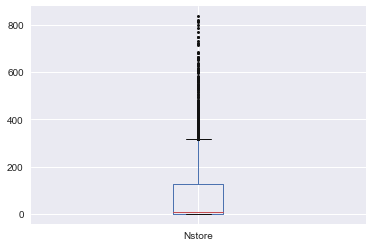

In [175]:
df.Nstore.plot(kind="box",sym='k.')

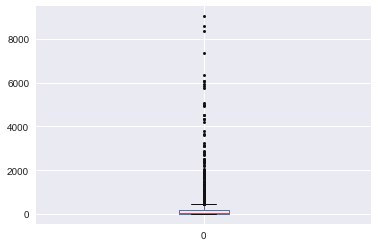

In [130]:
%matplotlib inline
f  = pd.DataFrame(y_data)

f.plot(kind="box",sym='k.');

### Train regressor

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1) 
regr = RandomForestRegressor(n_estimators=100,max_depth = 12 )
# regr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
#            max_features=None, max_leaf_nodes=None,
#            min_samples_leaf=6, min_samples_split=6, n_estimators=100, n_jobs=8)


regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
yt_pred = regr.predict(X_train)

MU = "uniform_average"


def adjusted_r2(X,y,r_squared):
    return r_squared
#     return  1 - ((1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1))


# scores = np.sqrt(cross_val_score(regr, X, y, cv=5, scoring='neg_mean_squared_error') * -1)
# print(scores)
# print(scores.mean(),np.median(scores))

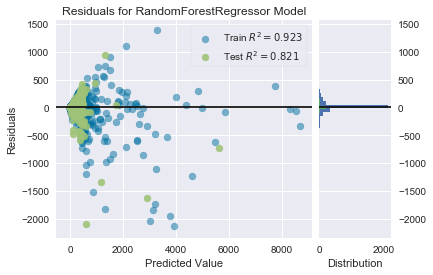

In [174]:
from yellowbrick.regressor  import ResidualsPlot

visualizer = ResidualsPlot(regr)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()       

### Save model

In [211]:
import pickle
from sklearn.externals import joblib
joblib.dump(regr,models_path+'regressor_std.pkl') 

['C:\\Users\\rahmim00\\Documents\\Notebooks\\Clustering\\pc_clustering\\notebooks\\7SEF\\..\\..\\models\\7SEF\\regressor_std.pkl']

In [28]:
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint


regr = RandomForestRegressor()

param_grid = {"n_estimators":[50,80,100,150,200],
              "max_depth": [8, 10, 12, 15, 20],
              "max_features": [None],
              "min_samples_split": [2, 3, 6, 10],
              "min_samples_leaf": [1, 3, 6, 10],
              "bootstrap": [True, False]
             }

# run grid search
grid_search = GridSearchCV(regr, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
grid_search.cv_results_

GridSearchCV took 3275.71 seconds for 800 candidate parameter settings.


C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set r

{'mean_fit_time': array([ 0.38287505,  0.6171813 ,  0.72938132,  1.15987865,  1.45589137,
         0.36238003,  0.62096834,  0.74161975,  1.08337895,  1.48730572,
         0.35055192,  0.57826797,  0.7074941 ,  1.08469566,  1.48222907,
         0.3574396 ,  0.57739298,  0.71242905,  1.15200861,  1.48207704,
         0.35558645,  0.57901271,  0.73440957,  1.10331432,  1.45231064,
         0.36801442,  0.60322396,  0.72606826,  1.13085675,  1.4550283 ,
         0.36952941,  0.58493169,  0.73628362,  1.08164605,  1.4327716 ,
         0.35655936,  0.56770468,  0.74493631,  1.1463817 ,  1.41803034,
         0.34739669,  0.55826966,  0.68638595,  1.08210238,  1.44501225,
         0.34306224,  0.56725033,  0.69508576,  1.10078367,  1.45842433,
         0.37680666,  0.5737834 ,  0.72885935,  1.16194129,  1.56698235,
         0.37694963,  0.59277701,  0.72754963,  1.09648728,  1.44182992,
         0.3364768 ,  0.55982526,  0.68639342,  1.02253366,  1.34708166,
         0.3388706 ,  0.53602505, 

In [27]:
grid_search.best_estimator_ 

NameError: name 'grid_search' is not defined

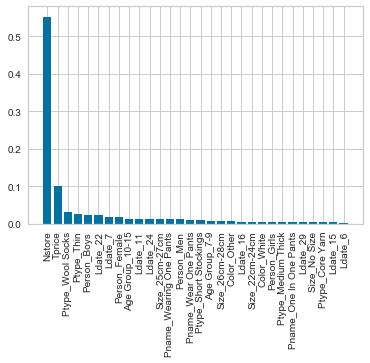

In [37]:
fi = regr.feature_importances_
sorted_indices = np.argsort(fi)[::-1]

imp = sorted_indices[:30]

plt.bar(range(len(imp)),fi[imp])
plt.xticks(range(len(imp)), X.columns[imp],rotation = 90)
plt.show()